# Comparison Between 3 Types of Prediction Models

 - The first model will be a linear classifier.
 - The second one will be an ensemble model.
 - The third will be a deep learning one.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.utils import resample, shuffle
from sklearn.metrics import recall_score, accuracy_score, classification_report,RocCurveDisplay, precision_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

In [2]:
RANDOM_STATE = 99

In [3]:
data = pd.read_csv("data/clinical_trial.csv")

## Explore

In [4]:
data.head()

,INTENSIVE,NEWSITEID,RISK10YRS,INCLUSIONFRS,SBP,DBP,N_AGENTS,NOAGENTS,SMOKE_3CAT,ASPIRIN,...,RACE4,CHR,GLUR,HDL,TRR,UMALCR,BMI,STATIN,SBPTERTILE,EVENT_PRIMARY
0,Regular,74.0,29.732061,True,145,80,2,False,3,True,...,WHITE,155,81,36,92,5.80,33.115201,True,3,False
1,Regular,8.0,29.677619,True,138,71,1,False,2,True,...,WHITE,243,107,61,188,5.45,28.842380,True,2,False
2,Intensive,25.0,17.443819,True,143,92,2,False,2,False,...,WHITE,180,116,47,125,13.33,33.643060,False,2,False
3,Regular,96.0,8.627849,False,123,68,2,False,1,False,...,WHITE,234,93,89,109,6.12,29.337871,False,1,False
4,Intensive,42.0,23.751437,True,126,51,2,False,2,False,...,WHITE,126,108,39,84,28.78,36.660286,False,1,False


In [5]:
data.columns

Index(['INTENSIVE', 'NEWSITEID', 'RISK10YRS', 'INCLUSIONFRS', 'SBP', 'DBP',
       'N_AGENTS', 'NOAGENTS', 'SMOKE_3CAT', 'ASPIRIN', 'EGFR', 'SCREAT',
       'SUB_CKD', 'RACE_BLACK', 'AGE', 'FEMALE', 'SUB_CVD', 'SUB_CLINICALCVD',
       'SUB_SUBCLINICALCVD', 'SUB_SENIOR', 'RACE4', 'CHR', 'GLUR', 'HDL',
       'TRR', 'UMALCR', 'BMI', 'STATIN', 'SBPTERTILE', 'EVENT_PRIMARY'],
      dtype='object')

In [6]:
data.shape

(8746, 30)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INTENSIVE           8746 non-null   object 
 1   NEWSITEID           8281 non-null   float64
 2   RISK10YRS           8746 non-null   float64
 3   INCLUSIONFRS        8746 non-null   bool   
 4   SBP                 8746 non-null   int64  
 5   DBP                 8746 non-null   int64  
 6   N_AGENTS            8746 non-null   int64  
 7   NOAGENTS            8746 non-null   bool   
 8   SMOKE_3CAT          8746 non-null   int64  
 9   ASPIRIN             8746 non-null   bool   
 10  EGFR                8746 non-null   float64
 11  SCREAT              8746 non-null   float64
 12  SUB_CKD             8746 non-null   bool   
 13  RACE_BLACK          8746 non-null   bool   
 14  AGE                 8746 non-null   int64  
 15  FEMALE              8746 non-null   bool   
 16  SUB_CV

# Preprocess

In [8]:
data.isnull().sum()

INTENSIVE               0
NEWSITEID             465
RISK10YRS               0
INCLUSIONFRS            0
SBP                     0
DBP                     0
N_AGENTS                0
NOAGENTS                0
SMOKE_3CAT              0
ASPIRIN                 0
EGFR                    0
SCREAT                  0
SUB_CKD                 0
RACE_BLACK              0
AGE                     0
FEMALE                  0
SUB_CVD                 0
SUB_CLINICALCVD         0
SUB_SUBCLINICALCVD      0
SUB_SENIOR              0
RACE4                   0
CHR                     0
GLUR                    0
HDL                     0
TRR                     0
UMALCR                  0
BMI                     0
STATIN                  0
SBPTERTILE              0
EVENT_PRIMARY           0
dtype: int64

There are 465 participants whom have an unknown site ID where they were treated.
We have 3 options:
 - Remove these 465 rows and suffer from data loss
 - Fill these values with an ID that is not in our dataset (for example: ID = 0)
 - Remove the `NEWSITEID` Column
 
 
We will fill the `na` values because dropping columns or rows could lead to data loss and we want to avoid that.

In [9]:
data['NEWSITEID'].unique()

array([ 74.,   8.,  25.,  96.,  42.,  13.,   4.,  44.,  nan,   1.,  21.,
        68.,  87.,  64.,  91.,  38.,  54.,  94.,  10.,  45.,  65.,  20.,
         2.,  97.,  60.,  76.,  88.,  33.,  32., 102.,  23.,  63.,  55.,
        92.,  48.,  47.,  95.,  12.,   5.,  15.,  19.,  22.,  81.,  70.,
        67.,  72.,  31.,  61.,  41.,  52.,  80.,  85.,   3.,  50.,  51.,
        57.,  82.,  98.,  59.,  56.,  27.,  79.,  40.,  11., 100.,  36.,
        99.,  18.,  89.,  37.,  58.,   9.,  71.,  24.,   6.,  43.,  29.,
        83.,  66.,  77.,  90.,  75.,  62.])

The ID 0 is not present in the `NEWSITEID` therfore we can safely assign the ID 0 to missing valus.

In [10]:
data_fill_na = data.fillna(0)

Now Let's look how many values there are from each target group (i.e. how many `true` and how many `false`)

In [11]:
print("Number of values")
print()
print("With filled na:")
print(data_fill_na['EVENT_PRIMARY'].value_counts())

Number of values

With filled na:
False    8207
True      539
Name: EVENT_PRIMARY, dtype: int64


Wow, this is a major problem. We have a lot of false values, but almost no true values.

Something must be done with this huge imbalanced data.

In [12]:
print(f"Percent of True values:  {len(data_fill_na[data_fill_na['EVENT_PRIMARY']==True])/len(data_fill_na)}")

Percent of True values:  0.06162817287903041


This is a tiny percentage

### Split data

In [13]:
def split(df):
    y = df['EVENT_PRIMARY']
    X = df.drop('EVENT_PRIMARY', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = split(data_fill_na.copy())

#### Creating our own preprocessing transformer

In [15]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        

#### Examine data metrics

In [16]:
data.describe()

,NEWSITEID,RISK10YRS,SBP,DBP,N_AGENTS,SMOKE_3CAT,EGFR,SCREAT,AGE,CHR,GLUR,HDL,TRR,UMALCR,BMI,SBPTERTILE
count,8281.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000
mean,55.820674,20.143798,139.704894,78.149325,1.837754,1.695632,71.689646,1.077442,67.893666,189.993025,98.907729,52.787674,126.092271,42.528651,29.882733,2.006403
std,29.743937,10.843465,15.623359,11.988268,1.035492,0.693989,20.684404,0.342435,9.432551,41.112715,13.614090,14.523649,84.036103,166.747879,5.786064,0.821080
min,1.000000,1.863811,72.000000,40.000000,0.000000,1.000000,14.660000,0.420000,50.000000,71.000000,44.000000,17.000000,23.000000,1.360000,13.734281,1.000000
25%,32.000000,12.051891,130.000000,70.000000,1.000000,1.000000,57.980000,0.860000,61.000000,161.000000,91.000000,43.000000,77.000000,5.630000,25.915815,1.000000
50%,58.000000,17.821904,138.000000,78.000000,2.000000,2.000000,71.310000,1.010000,67.000000,186.000000,97.000000,50.000000,107.000000,9.520000,29.041334,2.000000
75%,81.000000,25.762838,149.000000,86.000000,3.000000,2.000000,84.720000,1.210000,76.000000,214.000000,105.000000,60.000000,150.000000,21.430000,32.937432,3.000000
max,102.000000,81.187680,231.000000,134.000000,6.000000,3.000000,186.190000,4.040000,90.000000,437.000000,286.000000,161.000000,2414.000000,5000.000000,69.591365,3.000000


The values have different kinds of magnitudes. We will standardize the data

In [17]:
class Preprocessor(Preprocessor):
    def standardize(self, df):
        for col_name in df.columns:
            if not df[col_name].dtype == 'object' and not df[col_name].dtype == 'bool':
                scaler = StandardScaler()
                df[col_name] = scaler.fit_transform(np.array(df[col_name]).reshape(-1,1)).flatten()
        return df
    

Great, now we will convert categorical data into numeric data.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INTENSIVE           8746 non-null   object 
 1   NEWSITEID           8281 non-null   float64
 2   RISK10YRS           8746 non-null   float64
 3   INCLUSIONFRS        8746 non-null   bool   
 4   SBP                 8746 non-null   int64  
 5   DBP                 8746 non-null   int64  
 6   N_AGENTS            8746 non-null   int64  
 7   NOAGENTS            8746 non-null   bool   
 8   SMOKE_3CAT          8746 non-null   int64  
 9   ASPIRIN             8746 non-null   bool   
 10  EGFR                8746 non-null   float64
 11  SCREAT              8746 non-null   float64
 12  SUB_CKD             8746 non-null   bool   
 13  RACE_BLACK          8746 non-null   bool   
 14  AGE                 8746 non-null   int64  
 15  FEMALE              8746 non-null   bool   
 16  SUB_CV

There are 2 categorical columns: RACE4, INTENSIVE

We will create a categorical method convertor

In [19]:
class Preprocessor(Preprocessor):
    def cat(self, df):
        for col_name in df.columns:
            if(df[col_name].dtype == 'object'):
                df[col_name]= df[col_name].astype('category')
                df[col_name] = df.loc[:, col_name].cat.codes
        return df

### Handle imbalanced data


There are two main methods for handling imbalanced data: `Oversampling` and `Undersampling`. According to the following thread: https://stackoverflow.com/questions/44244711/imbalanced-data-undersampling-or-oversampling There are a few guidelines to choose one over the other:

 - Undesampling is used when there are lots (billions) of data points and we don't have sufficient compute or memory (RAM)
 - Undersampling may lead to worse performance due to data loss
 - Oversampling tends to work better as there is no loss of information
 
But we could also use the parameter `class_weight = 'balanced'` in each model to let it handle the imbalance by itself.

#### Finally Define the `fit` and `transform` methods

In [20]:
class Preprocessor(Preprocessor):
    def fit(self, X,y):
        return self
    
    def transform(self, X, y=None):
        X = self.standardize(X.copy())
        X = self.cat(X)
        return X

# Model Creation

3 Model comparisons

 - Linear classifier -    SVM
 - Ensemble model -       Bagging, Boosting, Stacking
 - Deep Learning -        ANN (Artificial Neural Network)
 
#### <ins>Reasons for choosing the models:<ins>

 - SVM: Our data is complex, and its theme (medical) is even more complex. it is not likely that our data is good for a linear classification model. nevertheless this model utilizing the kernel trick and it might uplift our predictions.
    
    
 - Ensemble: There is no definite good answer to which model is the best to choose. We don't know how any of the ensembles would behave so we will have to try all of them and pick the best one for comparison.
    
    
   
  - ANN: There are 4 main deep learning models: `ANN`, `CNN`, `Auto encoders`, `SOM`. `CNN` is good for several things, his main usage is for image processing, `Auto encoders` are mostly used for `NLP`, `Audio`, `Images` etc. and `SOM` Classifies features that are related to each other. All of these are not our case. We will use the `ANN` classifier because it is used as a good label classifier for our data set.
    
    
 
For all models we will use grid search with default 5 fold cross validation

**<ins>Evaluation:<ins>**
    This data set contains medical information, (specifically mortality classification - patient death or cardiovascular event).
    There is no room for mistakes. Classifying a patient as safe when he is not could lead tragedy, whereas classifying him as potentially in risk when he is not is not dangerous for us. 
    
 - We will use f1 as our main evaluation metric because we want to prevent the scenario where the model would guess only `True` for each data point and by that getting a low `precision` score

## Linear Model

We will use SVM model as our linear model, and try different kinds of kernel functions to see which one performs best

In [21]:
params = {
    "kernel": ('poly', 'sigmoid', 'rbf', 'linear'),
    'class_weight': ['balanced']
}
gs_svc = GridSearchCV(SVC(random_state=RANDOM_STATE), params, scoring = 'f1')
pipe_svc = Pipeline([('preprocessor', Preprocessor()), ("SVC", gs_svc)])
pipe_svc.fit(X_train, y_train)

pred = pipe_svc.predict(X_test)
print('------ Scores ------')
print(f"SVM |    Recall Score:  {round(recall_score(y_test, pred), 5)}, Accuracy Score: {accuracy_score(y_test, pred)}")


------ Scores ------
SVM |    Recall Score:  0.56738, Accuracy Score: 0.6986739826245999


#### SVM received poor results.

The `accuracy` score is low but `recall` score is what we are looking at, and it is even lower.

## Ensemble Model

For Ensemble models we will run `Bagging`, `Adaboost`, and `Stacking` with different kinds of weak estimators.

In [22]:
params_1 = { 'base_estimator': [DecisionTreeClassifier(max_depth=1, class_weight='balanced'), 
                               LogisticRegression(class_weight='balanced'),
                               ],
}
estimators = [
    ('per', Perceptron(random_state=RANDOM_STATE, class_weight='balanced')),      
    ('dtc',  DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')),
    ('sgd', SGDClassifier(random_state=RANDOM_STATE, class_weight='balanced'))

]
final_estimator = LogisticRegression(class_weight='balanced')

gs_bgc = GridSearchCV(BaggingClassifier(random_state=RANDOM_STATE), params_1, scoring = 'f1')
gs_abc = GridSearchCV(AdaBoostClassifier(random_state=RANDOM_STATE), params_1, scoring = 'f1')
gs_stc = GridSearchCV(StackingClassifier(estimators=estimators, final_estimator=final_estimator), {}, scoring = 'f1')
pipe_bgc = Pipeline([('preprocessor', Preprocessor()), ("Bagging", gs_bgc)])
pipe_abc = Pipeline([('preprocessor', Preprocessor()), ("Adaboost", gs_abc)])
pipe_stc = Pipeline([('preprocessor', Preprocessor()), ("Stacking", gs_stc)])

pipe_bgc.fit(X_train, y_train)
pipe_abc.fit(X_train, y_train)
pipe_stc.fit(X_train, y_train)


pred_bgc = pipe_bgc.predict(X_test)
pred_abc = pipe_abc.predict(X_test)
pred_stc = pipe_stc.predict(X_test)
print('------ Scores ------')
print(f"Bagging  |    Recall Score:  {round(recall_score(y_test, pred_bgc), 5)}, Accuracy Score: {accuracy_score(y_test, pred_bgc)}")
print(f"Adaboost |    Recall Score:  {round(recall_score(y_test, pred_abc), 5)}, Accuracy Score: {accuracy_score(y_test, pred_abc)}")
print(f"Stacking |    Recall Score:  {round(recall_score(y_test, pred_stc), 5)}, Accuracy Score: {accuracy_score(y_test, pred_stc)}")


------ Scores ------
Bagging  |    Recall Score:  0.5461, Accuracy Score: 0.67946959304984
Adaboost |    Recall Score:  0.58156, Accuracy Score: 0.6808413351623228
Stacking |    Recall Score:  0.2695, Accuracy Score: 0.8518518518518519


#### Ensemble Scores are similar

`Adaboost` performed better than `bagging` both in `accuracy` and `recall` score. `Stacking` performed better in accuracy score but worse in recall. We will choose `Adaboost` for the comparison because recall is more important to us.

## Deep Learning Model

Artificial Deep Neural Network

Knowing how many hidden layers and how many neurons is a tought task. According to this article: https://www.linkedin.com/pulse/choosing-number-hidden-layers-neurons-neural-networks-sachdev/ there are a few good guidelines:

 -  If data is less complex and is having fewer dimensions or features then neural networks with 1 to 2 hidden layers would work.
 -  The number of hidden neurons should be between the size of the input layer and the output layer.
 -  The most appropriate number of hidden neurons is sqrt(input layer nodes * output layer nodes)
 -  The number of hidden neurons should keep on decreasing in subsequent layers to get more and more close to pattern and feature extraction and to identify the target class.


 
 There are 29 feautres and 2 labels. Meaning:
 
 - The number of hidden neurons is between 2 and 29
 - The number of hidden neurons should be $sqrt(29 * 2) = 8$
 - The number of hidden layers would be between 1 or 2
 - The number of neurons in each hidden layer should decrease

Also accoring to the `Introduction to Neural Networks for Java, Second Edition by jeffheaton` one or two hidden layers is sufficient to approximate any smooth mapping to any accuracy

#### Choosing parameters

To fight the imbalance data we will change the learning_rate to `invscaling` (to gradually decreases the learning rate) with the solver `stochastic gradient descent`. The tuning parameters would be `activation` functions, `batch_size` and we will try different number hidden layers that follow the guidelines above

In [23]:
params = { 
    "hidden_layer_sizes": ( (5,3), (8,), (6,2,), (4,4), (7,1) ),
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate': ['invscaling'],
    'solver': ['sgd'],
    'batch_size': [50, 100, 500, 1000, 4000],
    'tol': [1e-3] # To make the model run faster!

}
gs_mlp = GridSearchCV(MLPClassifier(random_state=RANDOM_STATE), params, scoring = 'f1')
pipe_mlp = Pipeline([('preprocessor', Preprocessor()), ("MLP", gs_mlp)])
pipe_mlp.fit(X_train, y_train)

pred = pipe_mlp.predict(X_test)
print('------ Scores ------')
print(f"Neural Net |    Recall Score: {round(recall_score(y_test, pred), 5)}, Accuracy Score: {accuracy_score(y_test, pred)}")  


------ Scores ------
Neural Net |    Recall Score: 0.26241, Accuracy Score: 0.80612711476909


#### The results are not satisfying

The recall scores of this model are smaller than the `SVM` model

### Batch Size Analysis

First to replicate the Neural Net score, We will find the optimal parameters

In [24]:
pipe_mlp['MLP'].best_params_

{'activation': 'logistic',
 'batch_size': 500,
 'hidden_layer_sizes': (8,),
 'learning_rate': 'invscaling',
 'solver': 'sgd',
 'tol': 0.001}

In [25]:
for batch in range(100, 2000, 100):
    MLP = MLPClassifier(random_state=RANDOM_STATE, 
                        activation= 'logistic', 
                        hidden_layer_sizes = (8,), 
                        learning_rate= 'invscaling', 
                        solver='sgd', 
                        tol= 0.001,
                        batch_size=batch
                       )
    pip = Pipeline([('preprocessor', Preprocessor()), ("MLP", MLP)])
    pip.fit(X_train, y_train)
    pred = pip.predict(X_test)
    print(f"Batch: {batch} |    Recall Score: {round(recall_score(y_test, pred), 5)}, Accuracy Score: {accuracy_score(y_test, pred)}")  


Batch: 100 |    Recall Score: 0.0, Accuracy Score: 0.9355281207133059
Batch: 200 |    Recall Score: 0.0, Accuracy Score: 0.9350708733424783
Batch: 300 |    Recall Score: 0.02837, Accuracy Score: 0.928212162780064
Batch: 400 |    Recall Score: 0.11348, Accuracy Score: 0.8856881572930956
Batch: 500 |    Recall Score: 0.26241, Accuracy Score: 0.80612711476909
Batch: 600 |    Recall Score: 0.43262, Accuracy Score: 0.6625514403292181
Batch: 700 |    Recall Score: 0.46099, Accuracy Score: 0.6012802926383173
Batch: 800 |    Recall Score: 0.51773, Accuracy Score: 0.5368084133516232
Batch: 900 |    Recall Score: 0.55319, Accuracy Score: 0.4773662551440329
Batch: 1000 |    Recall Score: 0.6383, Accuracy Score: 0.4192958390489255
Batch: 1100 |    Recall Score: 0.68794, Accuracy Score: 0.36259716506630085
Batch: 1200 |    Recall Score: 0.68794, Accuracy Score: 0.3639689071787837
Batch: 1300 |    Recall Score: 0.68794, Accuracy Score: 0.36031092821216276
Batch: 1400 |    Recall Score: 0.73759, Accu

Look at that! We got a recall of 0.78014! The more we increase the batch size the better the recall. But it is not good as we thought. Like we said earlier, It is a tradeoff between the precision and the recall score. The accuracy plummets as the recall score gets higher. This is not what we want! A model with `0.277` accuracy is very bad. The `GridSearchCV` figured that the best batch size is `500` according to the `best_params_` parameter. By increasing the batch size we reduce the number of backpropagation and by that we increase the `True` label power but also neglecting the `False` label. It is a tradeoff.

In [26]:
print(f'Precision: {round(precision_score(y_test, pred), 5)}')

Precision: 0.06631


`0.06631` Precision!! this is bad, and not recommended.

# Model Comparison

models we will comapre:
 - SVC
 - Adaboost
 - Neural Net

#### Receiver operating characteristic (ROC)

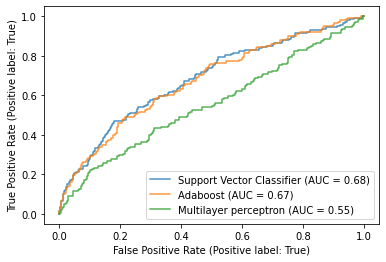

In [27]:
ax = plt.gca()
svm_roc = RocCurveDisplay.from_estimator(pipe_svc, X_test, y_test, ax=ax, alpha=0.8, name='Support Vector Classifier')
abc_roc = RocCurveDisplay.from_estimator(pipe_abc, X_test, y_test, ax=ax, alpha=0.8, name='Adaboost')
mlp_roc = RocCurveDisplay.from_estimator(pipe_mlp, X_test, y_test, ax=ax, alpha=0.8, name='Multilayer perceptron')


The models are Intermediate, The AUC scores are between `0.5` and `0.7`. `SVC` performed better than the rest but it is still similiar to `Adaboost`. `Neural Net` performed the worst

#### Raw Metrics

In [28]:
svm_report = pd.DataFrame(classification_report(y_test, pipe_svc.predict(X_test), output_dict=True)).T
abc_report = pd.DataFrame(classification_report(y_test, pipe_abc.predict(X_test), output_dict=True)).T
mlp_report = pd.DataFrame(classification_report(y_test, pipe_mlp.predict(X_test), output_dict=True)).T

In [29]:
accuracies_test = [svm_report.T['accuracy'][0], abc_report.T['accuracy'][0], mlp_report.T['accuracy'][0]]
accuracies_train = [accuracy_score(y_train, pipe_svc.predict(X_train)), accuracy_score(y_train, pipe_svc.predict(X_train)), accuracy_score(y_train, pipe_svc.predict(X_train))]

true_precision = [svm_report['precision'][1], abc_report['precision'][1], mlp_report['precision'][1]]
true_recall = [svm_report['recall'][1], abc_report['recall'][1], mlp_report['recall'][1]]
true_f1 = [svm_report['f1-score'][1], abc_report['f1-score'][1], mlp_report['f1-score'][1]]

false_precision = [svm_report['precision'][0], abc_report['precision'][0], mlp_report['precision'][0]]
false_recall = [svm_report['recall'][0], abc_report['recall'][0], mlp_report['recall'][0]]
false_f1 = [svm_report['f1-score'][0], abc_report['f1-score'][0], mlp_report['f1-score'][0]]

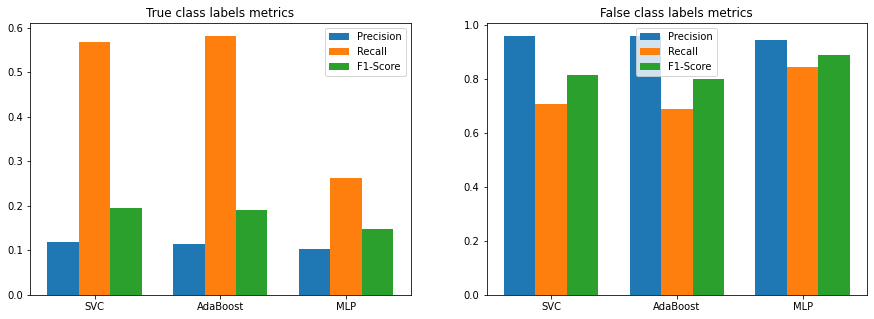

In [30]:
X = np.arange(3)
labels = ['SVC', 'AdaBoost', 'MLP']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].set_xticks(X, labels)
ax[0].bar(X - 0.25, true_precision, width = 0.25, label='Precision')
ax[0].bar(X + 0.00, true_recall, width = 0.25, label='Recall')
ax[0].bar(X + 0.25, true_f1, width = 0.25, label='F1-Score')
ax[0].set_title("True class labels metrics")
ax[0].legend()


ax[1].set_xticks(X, labels)
ax[1].bar(X - 0.25, false_precision, width = 0.25, label='Precision')
ax[1].bar(X + 0.00, false_recall, width = 0.25, label='Recall')
ax[1].bar(X + 0.25, false_f1, width = 0.25, label='F1-Score')
ax[1].set_title("False class labels metrics")
ax[1].legend()

Adaboost performed best for recalling the `True` labels which are crucial for saving lives, but on the other hand it performed slightly worse at predicitng the `False` labels compared to others but it is not a major concern for us.

#### Overfit Analysis

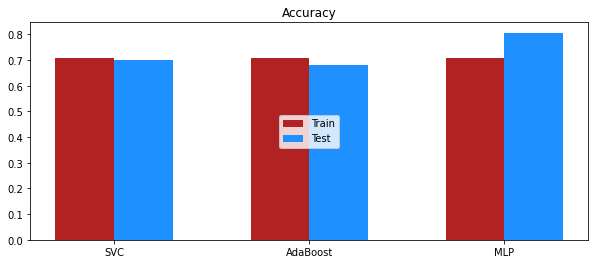

In [31]:
X = np.arange(3)
Y = np.arange(0, 1.1, 0.1)

labels = ['SVC', 'AdaBoost', 'MLP']
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xticks(X, labels)
ax.bar(X-0.15, accuracies_train, width = 0.3, color=['firebrick'], label='Train')
ax.bar(X+0.15, accuracies_test, width = 0.3, color=['dodgerblue'], label='Test')
ax.set_title("Accuracy")
ax.legend(loc=10, prop={'size': 10})

The train accuracy and the test accuracy and almost equal. Non of the models overfitted.

#### Visualize the Data 

Visualize the dataset in 2D and 3D to better understand why the models are performing poorly

In [32]:
pca = PCA()
proc = Preprocessor()
principals = proc.transform(X_train.copy())
principals = pca.fit_transform(principals)

principal_2 = principals[:, :2]
principal_3 = principals[:, :3]

principal_2_df = pd.DataFrame(data = principal_2, columns = ['pc1', 'pc2'])
principal_3_df = pd.DataFrame(data = principal_3, columns = ['pc1', 'pc2', 'pc3'])

principal_2_df['label'] = y_train
principal_3_df['label'] = y_train

#### 2D plot

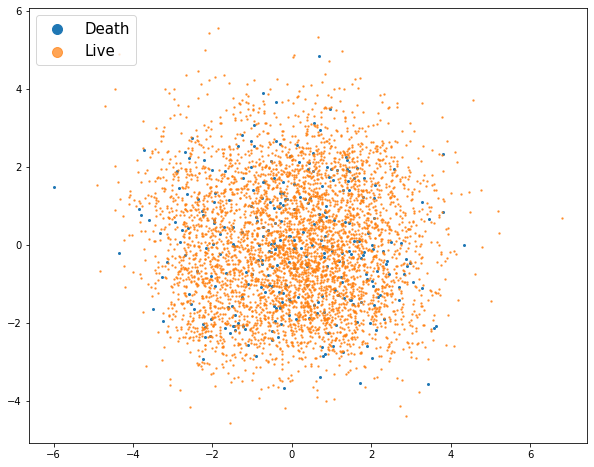

In [33]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

death = principal_2_df[principal_2_df["label"]==1]
live = principal_2_df[principal_2_df["label"]==0]
ax.scatter(death["pc1"], death["pc2"], label="Death", alpha = 1, s=4)
ax.scatter(live["pc1"], live["pc2"], label="Live", alpha = 0.7, s=2)
lgnd = ax.legend(loc=2, prop={'size': 15})
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]

Look at that! There is absolute no distinction between the sick patricipnats and the healthy ones

#### 3D plot

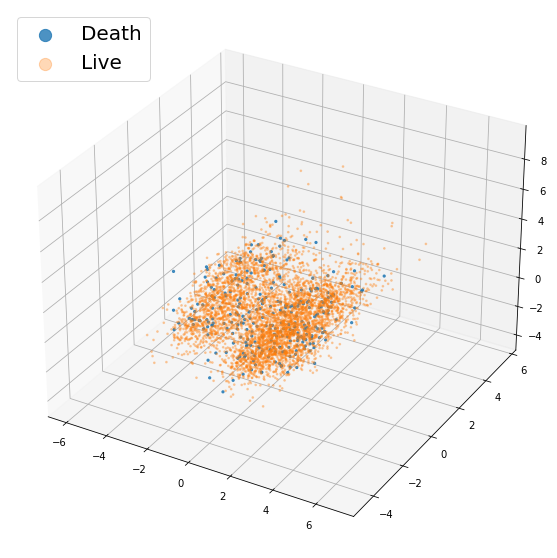

In [34]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
Death_3 = principal_3_df[principal_3_df["label"]==1]
Live_3 = principal_3_df[principal_3_df["label"]==0]
ax.scatter(Death_3["pc1"], Death_3["pc2"],Death_3["pc3"], label="Death", s=5, alpha=0.8)
ax.scatter(Live_3["pc1"], Live_3["pc2"],Live_3["pc3"], label="Live", s=3, alpha=0.3)
lgnd = ax.legend(loc=2, prop={'size': 20})
lgnd.legendHandles[0]._sizes = [150]
lgnd.legendHandles[1]._sizes = [150]

The same thing happens in 3D. The data is not separable atleast in the 2D and the 3D world

# Summary

We should have plotted that data with `PCA` before starting training the models because according to the plots above the data is hard to be separated by the `true` and `false` labels. All models we trained didn't perform good. Most of the models missed close to 50% (And the MLP model even more!) sick participants. We would not advise using this data for predictions, But if there is no choice then A human second opinion is a must in this case.